In [1]:
import os
import time
import glob
import random
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.applications.xception import (Xception, preprocess_input, decode_predictions)
from keras import backend as K

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from tensorflow.keras.models import load_model

Using TensorFlow backend.


In [5]:
df=pd.read_csv("reduced_labels_100.csv",encoding="utf-8")
df.nunique()
df.head(1)

,image_id,image_id2,label_id,url,pic_list
0,1600,1600,104,http://www.collection.com.tw/images/201204/133...,all_100\1600.jpeg


In [6]:
photos=df['pic_list'].tolist()
photos[:1]

['all_100\\1600.jpeg']

In [7]:
def model_A(num_classes):
    # Create the CNN Model------
    model = Sequential()
    model.add(Conv2D(20, (3, 3), strides=(1, 1),input_shape=(100,100,3), data_format='channels_last', activation='relu') )
    model.add(Conv2D(30, (3, 3), strides=(1, 1), data_format='channels_last', activation='relu') )
    model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last' ))
    model.add(Dropout(0.25)) 
    model.add(Flatten()) 
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss="categorical_crossentropy",optimizer="adam", metrics=['accuracy'])
    #model.summary()
    return model

def model_B(num_classes,wt):
    # Create the CNN Model------
    model = Sequential()
    model.add(Conv2D(20, (3, 3), strides=(1, 1),input_shape=(100,100,3), data_format='channels_last', activation='relu') )
    model.add(Conv2D(30, (3, 3), strides=(1, 1), data_format='channels_last', activation='relu') )
    model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last' ))
    model.add(Dropout(0.25)) 
    model.add(Flatten()) 
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.load_weights(wt)
    model.compile(loss="categorical_crossentropy",optimizer="adam", metrics=['accuracy'])
    #model.summary()
    return model


In [8]:
def model_run(file, n,mmodel,ep ):

    image_size=(100,100)
    total_images = n
    
    array_x= np.zeros((total_images, image_size[0], image_size[1], 3))    
    image_id2 = []
    checked=[]
    for i, infile in enumerate(samples):  
        img = image.load_img(infile, target_size=image_size) # keras 'image'
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        array_x[i,:] = x

        path, filename = os.path.split(infile)     
        file_number, jpeg=filename.split('.')
        image_id2.append(file_number)
        checked.append('yes')
    
    
    col = {'image_id': image_id2,'image_id2': image_id2, 'checked': checked}
    df1=pd.DataFrame(data=col)    
    
    # y_train
    df2=pd.read_csv("B_labels.csv", encoding="utf-8") #ordered
    df1['image_id']=df1['image_id'].astype(int)
    df2['image_id']=df2['image_id'].astype(int)
    df2['label_id']=df2['label_id'].astype(str)
    df_new = pd.merge(left=df1, right=df2,how='left', left_on='image_id',right_on='image_id') 
    
    #i) normalize and reshape the x_train
    # x_train, x_test, y_train, y_test = train_test_split(array_x, y, random_state=1, stratify=y)
    x_train=array_x
    x_train = x_train.astype("float32")/255.0
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],x_train.shape[2],3)
    #x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],x_test.shape[2],3)
 
    #ii) categorize and reshape y_train
    y_train = df_new["label_id"] 
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train)
    encoded_y_train = label_encoder.transform(y_train)
        
    num_classes =65
    y_trains = to_categorical(encoded_y_train , num_classes)
    
    model=mmodel
    model.fit(x_train,y_trains,batch_size=20,epochs=ep,shuffle=True,verbose=2)
    
    #save model
    model.save("model_saved3.h5")
    
    return label_encoder
   

### Start  to run!!!

In [9]:
#total 81251 samples
i_start = time.time()
for i in range(1):    
    print (f'number of images in the photos file before random sampling: {len(photos)}')
    sample_size=2000
    ep=1
    samples=random.sample((photos),sample_size)
    #print(samples[:5])
    
    # delete the trained samples from the original photo lists
    for filename in samples:
        photos.remove(filename) 
    print (f'number of images left in the photos file after random sampling: {len(photos)}')
     
    if i==0: 
        print(f'ROUND:{i}')
        #model_run(samples,sample_size,model_A(65),ep)
        model1=model_run(samples,sample_size,model_B(65, "model_saved_100.h5"),ep) 
        print
        print(f'----------------------------------')
        print
    else:
        print(f'ROUND:{i}')
        model1=model_run(samples,sample_size,model_B(65, "model_saved_100.h5"),ep)    
        print
        print(f'----------------------------------')
        print
        
# samples=photos
# print(f'\n')  
# print (f'number of images in the photos file left: {len(photos)}')
# print(samples[:5])
# print(f'last round:') 
# model=model_run(samples,len(samples),model_B(65, "model_saved_100.h5"),ep)  
# print

# i_end = time.time()
# print(f'----------------------------------')
# print
# print(f'Total running time :{i_end - i_start} sec ~ {(i_end - i_start)/60} mins...')
# print


number of images in the photos file before random sampling: 81251


W0718 18:26:26.554680 4797756864 deprecation_wrapper.py:119] From /anaconda3/envs/Playground/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 18:26:26.568345 4797756864 deprecation_wrapper.py:119] From /anaconda3/envs/Playground/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 18:26:26.574680 4797756864 deprecation_wrapper.py:119] From /anaconda3/envs/Playground/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 18:26:26.596621 4797756864 deprecation_wrapper.py:119] From /anaconda3/envs/Playground/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0718 18:26

number of images left in the photos file after random sampling: 79251
ROUND:0


FileNotFoundError: [Errno 2] No such file or directory: 'all_100\\10840.jpeg'

## Loading and Evaluating the loaded model-- between 1 and 3

In [111]:
model = load_model("model_saved_100.h5") #2) new randomized 100px

In [112]:
#model = load_model("Jmodel_3.h5")  #3) Josh-200px 

In [113]:
dg=pd.read_csv("B_reduced_labels.csv",encoding="utf-8")
dg1=dg[dg['label_id']==37][:5]  #bet 1-128
dg1

,image_id,image_id2,label_id,text_id,url,pic_list
8370,15450,15450.jpeg,37,Light Fixtures,http://pic17.photophoto.cn/20101228/0037037335...,all_200\15450.jpeg
8371,15451,15451.jpeg,37,Light Fixtures,https://www.waldens-lighting.com/archive/produ...,all_200\15451.jpeg
8372,15452,15452.jpeg,37,Light Fixtures,https://img.alicdn.com/imgextra/TB2ZXkVvUhnpuF...,all_200\15452.jpeg
8373,15453,15453.jpeg,37,Light Fixtures,https://img.alicdn.com/imgextra/TB2in4MXmOI.eB...,all_200\15453.jpeg
8374,15454,15454.jpeg,37,Light Fixtures,https://img14.360buyimg.com/imgzone/jfs/t2587/...,all_200\15454.jpeg


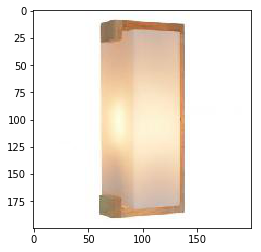

In [114]:
picture="15451.jpeg"

image_size2 = (200, 200)
image_path2 = os.path.join("all_200", picture) 
img2 = image.load_img(image_path2, target_size=image_size2)
plt.imshow(img2)
# 4933.jpeg,13540.jpeg(rug),5767.jpeg(sofa/bed),41647.jpeg(Chandelier)
# 4933.jpeg, 1600.jpeg, 119405.jpeg 12031.jpeg,138821.jpeg,183578.jpeg,27336.jpeg (clock),13537.jpeg (rug)
#116272.jpeg (Storage Containers)
# 94695.jpeg(lamp),47451.jpeg (Light Fixtures)
#140547:better with #2model


image_size1 = (100, 100)
image_path1 = os.path.join("all_100", picture)#all_100
img1 = image.load_img(image_path1, target_size=image_size1)

In [115]:
# describe your item!

x = image.img_to_array(img1)
x = np.expand_dims(x, axis=0)
x_ques = x.astype("float32")/255.0
x_quest = x_ques.reshape(x_ques.shape[0], x_ques.shape[1],x_ques.shape[2],3)
# model.predict(x_quest).round()
#print(f"Predicted class: {model.predict_classes(x_quest)}")
#model1.save("encoder.h5")

label_encoder=model1
encoded_predictions = model.predict_classes(x_quest)
prediction_labels = label_encoder.inverse_transform(encoded_predictions)
k=int(prediction_labels[0])
dg=pd.read_csv("B_reduced_labels.csv",encoding="utf-8")
#dg.head(1)

furn_type=dg[dg['label_id']==k]['text_id'].tolist()
furn_type[0]

print(f" Predicted class: {k}")
print(f" Describe the class :  {furn_type[0]}")

 Predicted class: 37
 Describe the class :  Light Fixtures
